In [1]:
push!(LOAD_PATH, pwd())
using LightGraphs, IndirectRec, GraphConnectivityTheory,GraphCreation
using PyCall, PyPlot, Distributions

INFO: Recompiling stale cache file /Users/julian/.julia/lib/v0.5/HDF5.ji for module HDF5.
INFO: Recompiling stale cache file /Users/julian/.julia/lib/v0.5/LightGraphs.ji for module LightGraphs.
INFO: Recompiling stale cache file /Users/julian/.julia/lib/v0.5/PyPlot.ji for module PyPlot.


## $P_{known}$ for gossip percolation among friends.

We consider a special model of gossip where we allow paths of transmission of arbitrary length, with the restriction that every node on the path must be connected to the node about which gossip is spread.
This captures the intuition that gossip is only "fun" when both parties know the subject of the gossip.

We model the clique of $k$ friends as an Erdos-Renyi random graph with $k$ nodes and edge probability $c$ (the local clustering coefficient). The ego node is connected to every one of the nodes of the Erdos Renyi graph.

After applying gossip, the connection probability among friends reduces to $p c$ and the connection probability from ego to a given friend becomes $p$.

We are interested in the probability $P$ that ego will be connected to a given friend. Following the derivation of the random graph reliability function, we develop the following terms:

$$1 - P = \sum_{j = 1}^{k} A_{j}(p c) \binom{k}{j} (1 - p c)^{j (k - j)} \frac{j}{k} (1 - p)^{j}$$

where $A_n(x)$ is the reliability function (probability of being fully connected) of a complete graph of $n$ nodes with edge reliability $x$.


The derivation of this expression is as follows. Consider a specific node $1$ from the friend clique.
Each term on the right hand side is the probability that node $1$ is part of a connected component of size exactly $j$, and that the ego node is _not_ connected to that component.
This is the probability of having such a connected component $A_j(p c)$.
We must factor in the multiplicity $\binom{k}{j}$ of picking the nodes in the connected component.
Further, with probability $\frac{j}{k}$, node $1$ will be part of that component.
Every of the $j$ nodes in the component must be disconnected from the $k-j$ nodes outside of the component.
Finally, the ego node must be disconnected from all $j$ nodes in the component. 

Thus we have enumerated all possibilities where the ego node is _not_ connected to node $1$. The remaining probability must be the probability that they _are_ connected. This reasoning is similar to Gilbert (1959, Random Graphs)

In [2]:
N = 20
change = true
p_range = 0.0:0.025:1.0
c = 0.1
P_range = similar(p_range)
if change
    P_clique_range = similar(p_range)*0
end
P_th_clique_range = similar(p_range)*0
P_th_range = similar(p_range)
num_trials = 50
num_trials_clique = 40


40

In [229]:
#Generate data to compare
for (i,p) in enumerate(p_range)
#      P_range[i] = get_p_known_percolation(g,p,N,num_trials)[end]
#     P_th_range[i] = convert(Float64,get_p_known_percolation_theory(N,1,p))
    P_range[i] = convert(Float64,get_p_known_percolation_theory(N+1,1,p))
    P_th_range[i] = convert(Float64,get_p_known_percolation_theory(N+1,1,p*c))
#     P_th_clique_range[i] = get_p_known_clique_t(N,c,p)# convert(Float64,get_p_known_percolation_theory(N+1,1,p))
    P_th_clique_range[i] = get_p_known_clique_theory(N,c,p)# convert(Float64,get_p_known_percolation_theory(N+1,1,p))
#     P_th_clique_range[i] = get_p_known_clique_theory_approx(N,c,p)# convert(Float64,get_p_known_percolation_theory(N+1,1,p))

    if change
        for j = 1:num_trials_clique
            h = produce_clique_graph(N,c)
            P_clique_range[i] += get_p_known_percolation(h,p,N,num_trials)[1][end] 
        end
        P_clique_range[i] /= num_trials_clique
    end

end

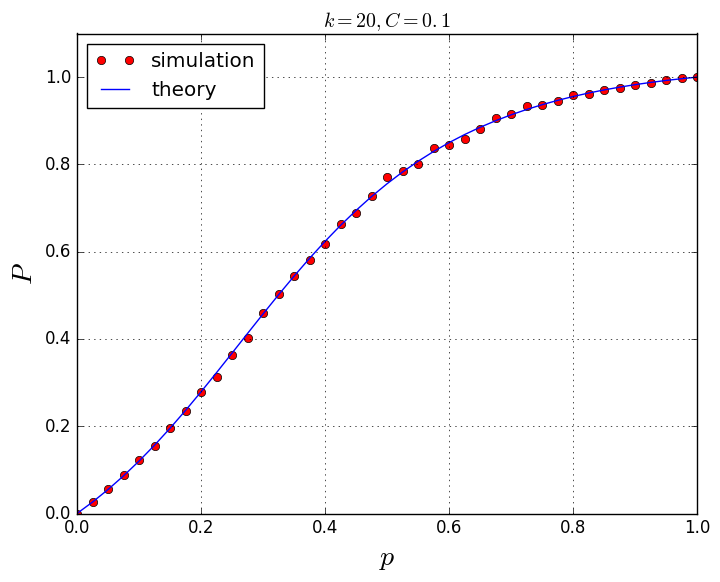

PyObject <matplotlib.legend.Legend object at 0x3322a04d0>

In [230]:
# plot(p_range,P_range,"--b",label=L"P_{N+1}^{p}")
# plot(p_range,P_th_range,label=L"P_{N+1}^{p c}")
plot(p_range,P_clique_range,"or",label="simulation")
plot(p_range,P_th_clique_range,label="theory")
# f(x) = 1 - (1 - x).^(N/2)
# plot(p_range,f(p_range)./f(c*p_range), label=L"\frac{p(1-p)}{p c (1 - p c)}")
grid()
ylim([0,1.1])
xlabel(L"p",size=20)
ylabel(L"P",size=20)
title(latexstring("\$ k = $N, C = $c \$" ))
legend(loc = "best")

In [3]:


function produce_clique_graph(N,c::Float64)
    h = erdos_renyi(N,c)
    add_vertex!(h)
    vert = vertices(h)
    new_v = length(vert)
    for w in vert 
        if new_v != w
            add_edge!(h,new_v,w)
        end
    end
    h
end

function get_p_known_clique_theory(k::Int,c::Float64,p::Float64)
    if k == 0
        return 0
    end
    N = k 
    curr = 0
    p_c = p*c
    An_vec = GraphConnectivityTheory.memoize_An(BigInt(N),BigFloat(p_c))
    for i = 1:N
        curr += An_vec[i]*binomial(BigInt(N),BigInt(i))*(1-p_c)^(i*(N-i))*(i/N)*(1-p)^(i)
    end
    return 1 - curr
end   

function get_p_known_clique_theory_approx(k::Int,c::Float64,p::Float64)
    N = k 
    curr = 0
    p_c = p*c
    An_vec = get_An_approx(collect(1:N),p_c)
    for i = 1:N
        curr += An_vec[i]*binomial(BigInt(N),BigInt(i))*(1-p_c)^(i*(N-i))*(i/N)*(1-p)^(i)
    end
    return 1 - curr
end   
# g = Graph(N,round(Int,N*(N-1)/2))
# h = produce_clique_graph(N,0.4) 

get_p_known_clique_theory_approx (generic function with 1 method)

## Approximations to the reliability function

In [212]:
n = 50
p = 0.8
Ans = GraphConnectivityTheory.memoize_An(BigInt(n),BigFloat(p));

function get_An_approx(n,p)
    return 1 - n.*(1-p).^(n-1)
end

get_An_approx (generic function with 1 method)

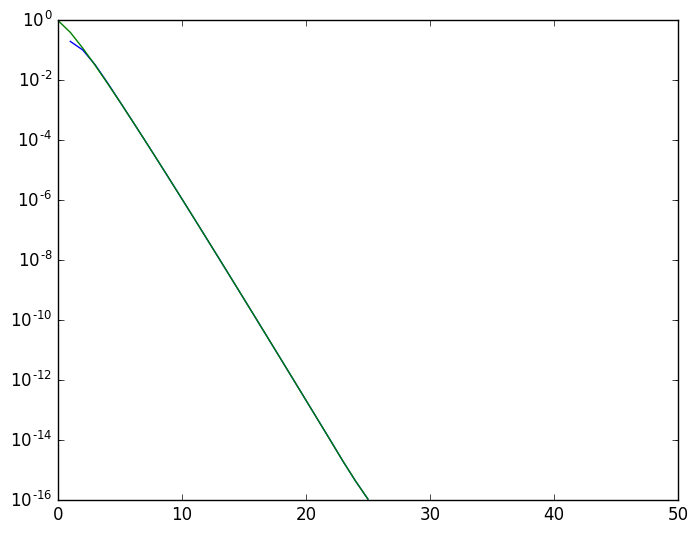

1-element Array{Any,1}:
 PyObject <matplotlib.lines.Line2D object at 0x330929fd0>

In [213]:
n_range = collect(1:n)
semilogy(1-[convert(Float64,_) for _ in Ans])
semilogy(1-get_An_approx(n_range,p))

In [4]:
function get_p_known_clique_percolation(g::LightGraphs.Graph,p::Real,num_trials = 100)
    p_knowns = zeros(size(LightGraphs.vertices(g)))
    singletons = IndirectRec.get_singleton_nodes_array(g)
    for i in 1:num_trials
        h = IndirectRec.sample_graph_edges(g,p)
        p_knowns += get_p_known_clique(g,h)
    end
    p_knowns /= num_trials
    return p_knowns,mean(p_knowns[!singletons])
end


function get_p_known_clique(g::LightGraphs.Graph,h::LightGraphs.Graph)
    p_knowns = zeros(size(LightGraphs.vertices(g)))
    for v in LightGraphs.vertices(g)
        p_knowns[v] = get_p_known_clique(g,h,v)
    end
    return p_knowns
end

function get_p_known_clique(g::LightGraphs.Graph,h::LightGraphs.Graph,v::Int)
    curr_neighbors = LightGraphs.neighbors(g,v)
    clique_members = vcat([v],curr_neighbors) 
    clique,vmap = LightGraphs.induced_subgraph(h,clique_members)
    vmap = reverse_vmap(vmap)
    curr_neighbors_mapped = map_vertices(vmap,curr_neighbors)
    components = IndirectRec.get_components(clique)
    p_known = get_p_known_given_components(components,vmap[v],curr_neighbors_mapped)
    return p_known
end

function map_vertices(vmap::Dict{Int,Int},vs::Array{Int,1})
    vs_new = zeros(vs)
    for i in 1:length(vs)
        vs_new[i] = vmap[vs[i]]
    end
    vs_new
end
    
function reverse_vmap(vmap::Array{Int,1})
    vmap_r = Dict{Int,Int}()
    for (i,v) in enumerate(vmap)
        vmap_r[v] = i
    end
    vmap_r
end
    
function get_p_known_given_components(components::IndirectRec.GraphComponents,v::Int,candidates::Array{Int,1})
    p_known = 0
    nc = length(candidates)
    if nc > 0
        for w in candidates
            if IndirectRec.nodes_in_same_component(v,w,components)
                p_known += 1.0
            end
        end
        p_known /= nc
    end
    return p_known
end
    
    
        
    

get_p_known_given_components (generic function with 1 method)

In [151]:
using GraphCreation

graph_type = :watts_strogatz
N = 1000
k = 20
C = 0.2
g = GraphCreation.create_graph(N,k,graph_type,C)
# g = erdos_renyi(100,0.1)

ks = degree(g)
cs = local_clustering_coefficient(g)
p = 0.4
IndirectRec.get_singleton_nodes_array(g)
@time p_knowns,_ = get_p_known_clique_percolation(g,p,100)
p_knowns_th = zeros(nv(g))
@time for v in 1:nv(g)
    p_knowns_th[v] = get_p_known_clique_theory(ks[v],cs[v],p) 
end

  4.741559 seconds (33.32 M allocations: 2.771 GB, 7.44% gc time)
  0.828820 seconds (9.19 M allocations: 265.228 MB, 30.67% gc time)


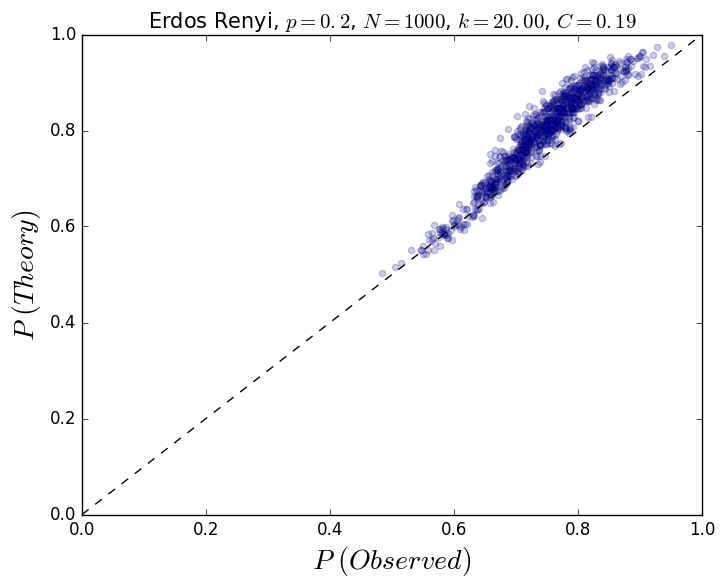

PyObject <matplotlib.text.Text object at 0x34800c850>

In [295]:
# scatter(1:nv(g),p_knowns,color="r")
scatter(p_knowns,p_knowns_th,alpha=0.2)
xx = 0:0.1:1
plot(xx,xx,"--k")
xlim([0,1])
ylim([0,1])
xlabel(latexstring("P \\ (Observed)"),size=20)
ylabel(latexstring("P \\ (Theory)"),size=20)
title_str = latexstring("Erdos Renyi, \$p = $p\$, \$N = $(nv(g))\$, \$k = $(@sprintf("%.2f",mean(ks)))\$, \$C = $(@sprintf("%.2f",mean(cs)))\$")
title(title_str,size=15)

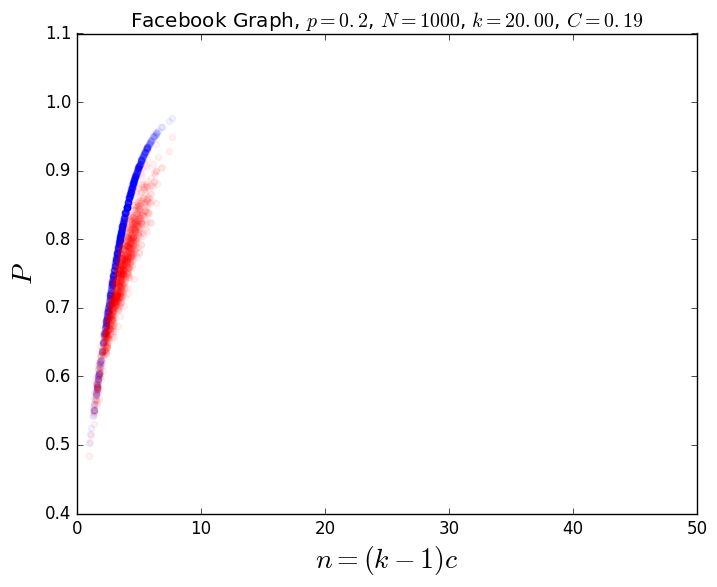

In [296]:
# scatter(cs_fb.*(ks_fb-1),p_knowns_th_fb,color="b",alpha=0.05,label="theory")
# scatter(cs_fb.*(ks_fb-1),p_knowns_fb,color="r",alpha=0.05,label="observation")

scatter(cs.*(ks-1),p_knowns_th,color="b",alpha=0.05)
scatter(cs.*(ks-1),p_knowns,color="r",alpha=0.05)

title_str = latexstring("Facebook Graph, \$p = $p\$, \$N = $(nv(g))\$, \$k = $(@sprintf("%.2f",mean(ks)))\$, \$C = $(@sprintf("%.2f",mean(cs)))\$")
title(title_str)
xlim([0,50])
xlabel(L"n = (k-1)c",size=20)
ylabel(L"P",size=20)
legend(loc="lower right")


In [294]:
# p_knowns_fb = p_knowns
# p_knowns_th_fb = p_knowns_th
nv(g),mean(cs),mean(ks)

(1000,0.19290121639611854,20.0)

For the Watts Strogatz model this theory works least well because the "randomness assumption" of which neighbor is connected to whom is least true. We have a group of local neighbors that are all connected. We have a group of global neighbors that are almost surely not connected to any other neighbors.

## Exploring the theoretical predictions.

In [290]:
p = 0.2
k_range = collect(1:5:150)
c_range = collect(0:0.1:1)
k_grid = repmat(k_range,1,length(c_range))
c_grid = repmat(c_range',length(k_range),1)
p_knowns_range = zeros(length(k_range),length(c_range))

@time for i in 1:length(k_range)
    for j in 1:length(c_range)
        p_knowns_range[i,j] = get_p_known_clique_theory(k_range[i],c_range[j],p) 
    end
end

  5.494372 seconds (51.14 M allocations: 1.429 GB, 26.58% gc time)


In [288]:
size(k_grid),size(c_grid)

((8,51),(8,51))

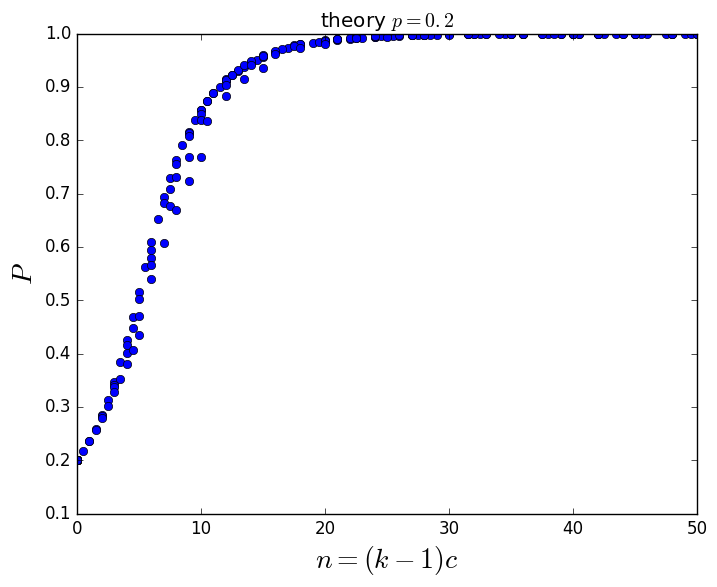

(0,50)

In [292]:
close("all")
pygui(false)
figure()
plot(c_grid[:].*(k_grid[:]-1),p_knowns_range[:],"o")
xlabel(L"n = (k-1)c",size=20)
title(L"theory $p = 0.2$")
ylabel(L"P",size=20)
xlim([0,50])

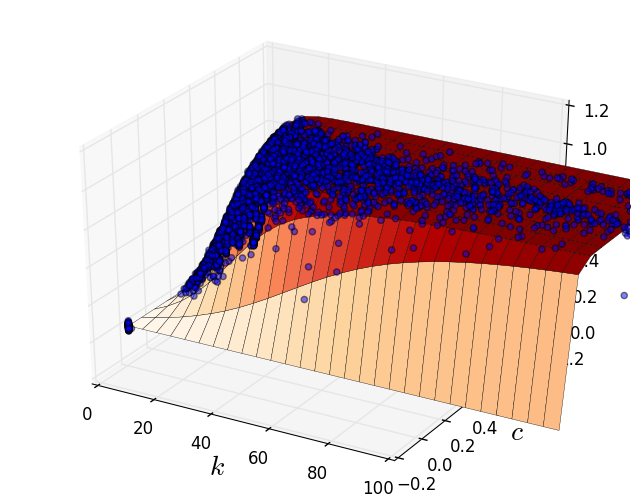

(0,100)

In [293]:
close("all")
ax = figure()[:add_subplot](1,1,1, projection="3d")
ax[:scatter3D](ks_fb,cs_fb,p_knowns_fb,alpha=0.5)
ax[:plot_surface](k_grid,c_grid, p_knowns_range, edgecolors="k",cstride=1,rstride=1, 
cmap=ColorMap("OrRd"), alpha=1.0, linewidth=0.25)
xlabel(L"k",size=20)
ylabel(L"c",size=20)
zlabel(L"P",size=20)
xlim([0,100])
# pygui(true)
# ion()

 The probability that it is connected to a given node is
$p + (1 - p)*(1 - (1 - p*p_{perc})^k)$

In [214]:
function get_p_known_clique_t(k::Int,c::Float64,p::Float64)
    N = k 
    p_c = p*c
    p_perc = percolation_erdos_renyi(N+1,p_c)
    p_perc_higher = percolation_erdos_renyi(N+1,p)
    f(x) = (1 - (1 - x)^(N-1))
#     return p + (1-p)*(p_perc - p_c)/((1-p_c)) 
#     return (1-p)*p_perc + p*p_perc_higher
    return p  + (1 - p)/(1 - p_c)*(p_perc - p_c)*f(p)/f(p_c)
end
    
function get_p_known_clique(k::Int,c::Float64,p::Float64)
    N = k 
    p_c = p*c
    p_perc = percolation_erdos_renyi(N+1,p_c)
    return p + (1-p)*p*(p_perc - p_c)/((1-p_c)*p_c) 
end

function prefac(p,c)
    p_c = p*c
    return (1 + p_c - p) / (c)
end

prefac (generic function with 1 method)

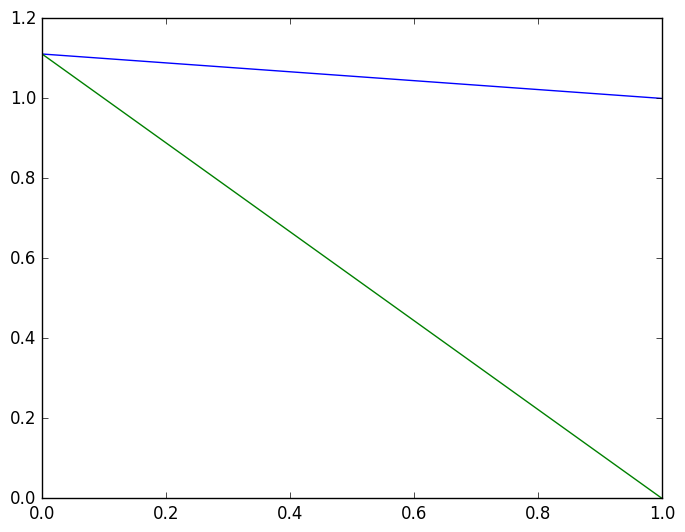

1-element Array{Any,1}:
 PyObject <matplotlib.lines.Line2D object at 0x3275c65d0>

In [11]:
c = 0.9
pr = 0:0.01:1
plot(pr,prefac(pr,c))
plot(pr,1/c - pr * 1/c)

 The probability that it is connected to a given node is
$p + (1 - p)*(1 - (1 - p*p_{perc})^k)$

## TODO what data can we use to test the prediction that cooperation is highly predicted by $n = (k-1) c$.